In [13]:
import pandas as pd
import cooler
from cooltools import insulation
import glob, os
from pybedtools import BedTool as pbt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### 1. Call TAD borders - merged maps

In [3]:
path_to_maps = "../data/"
resolution = 15_000
clr_odc= cooler.Cooler(f'{path_to_maps}::/resolutions/{resolution}')

In [4]:
insulation_table = insulation(clr_odc, [120_000], min_frac_valid_pixels=0.76,  min_dist_bad_bin=10, verbose=False)

In [8]:
window = 120
map_size = 15
directory = "../data"

boundaries = insulation_table[insulation_table[f"is_boundary_{window}000"] == True]
boundaries = boundaries[["chrom", 'start', 'end',f"boundary_strength_{window}000", f"log2_insulation_score_{window}000"]]
boundaries.to_csv(f"{directory}/boundaries_plus_maps_112022_{map_size}_{window}kb_params.bed",sep="\t", header=None,index=False)
boundaries.to_csv(f"{directory}/boundaries_plus_maps_112022_{map_size}_{window}kb_params.csv",index=False)

insulation_table.to_csv(f"{directory}/insulation_score_odc_{map_size}_{window}kb_params.bed",sep="\t", header=None,index=False)
insulation_table.to_csv(f"{directory}insulation_score_odc_{map_size}_{window}kb_params.csv", index=False)


### 2. Call TAD borderes - individual maps

In [5]:
path_to_maps = "../data"
os.chdir(path_to_maps)
files= []
for file in glob.glob("*.mcool"):
    files.append(file)
files

['sampled_HC-318plus_drop_diag_1K.mcool',
 'sampled_HC-91minus_drop_diag_1K.mcool',
 'sampled_HC-3Mplus_drop_diag_1K.mcool',
 'sampled_HC-318minus_drop_diag_1K.mcool',
 'sampled_HC-91plus_drop_diag_1K.mcool',
 'sampled_HC-2Mplus_drop_diag_1K.mcool',
 'sampled_HC-3Mminus_drop_diag_1K.mcool',
 'sampled_HC-2Mminus_drop_diag_1K.mcool']

In [6]:
resolution = 15_000
window = 120
map_size = 15

for file in files:
    clr = cooler.Cooler(f'{path_to_maps}/{file}::/resolutions/{resolution}')
    insulation_table = insulation(clr, [120_000], min_frac_valid_pixels=0.82,  min_dist_bad_bin=10, verbose=False)
    boundaries_minus_param2 = insulation_table[~insulation_table.log2_insulation_score_120000.isna()]
    boundaries_minus_param2 = boundaries_minus_param2[["chrom", 'start', 'end',f"log2_insulation_score_{window}000"]]
    boundaries_minus_param2.to_csv(f"../data/full_insulation_score_{file.split('_')[1]}.bedGraph",sep="\t", header=None,index=False)


### 2.Plot PCA based on insulation

In [7]:
# create multibed.bed file using bedtools. This file should be an intersection of all used .bed files: multiinter [OPTIONS] -i FILE1 FILE2 .. FILEn
multibed = pd.read_csv(f"../data/multibed.bed", sep="\t") #set path to .bed
multibed = multibed[multibed.num == 8]

In [8]:
HC_318minus = pd.read_csv(f"../data/full_insulation_score_{files[0].split('_')[1]}.bedGraph",sep="\t", header=None)
sample_3Mplus = pd.read_csv(f"../data/full_insulation_score_{files[1].split('_')[1]}.bedGraph",sep="\t", header=None)
sample_2Mminus = pd.read_csv(f"../data/full_insulation_score_{files[2].split('_')[1]}.bedGraph",sep="\t", header=None)
sample_3Mminus = pd.read_csv(f"../data/full_insulation_score_{files[3].split('_')[1]}.bedGraph",sep="\t", header=None)

sample_91plus = pd.read_csv(f"../data/full_insulation_score_{files[4].split('_')[1]}.bedGraph",sep="\t", header=None)
sample_2Mplus = pd.read_csv(f"../data/full_insulation_score_{files[5].split('_')[1]}.bedGraph",sep="\t", header=None)
sample_318plus = pd.read_csv(f"../data/full_insulation_score_{files[6].split('_')[1]}.bedGraph",sep="\t", header=None)
sample_91minus = pd.read_csv(f"../data/full_insulation_score_{files[7].split('_')[1]}.bedGraph",sep="\t", header=None)

dfs = [HC_318minus, sample_3Mplus, sample_2Mminus,sample_3Mminus,sample_91plus,sample_2Mplus,sample_318plus,sample_91minus ]
names = [i.split('_')[1] for i in files]

In [11]:
df_res_final = pd.DataFrame()
for df, name  in zip(dfs, names):
    df2 = pbt.from_dataframe(df).intersect(pbt.from_dataframe(multibed[["chrom","start","end"]]))
    df2 = pd.read_table(df2.fn,header = None)
    df_res = df2[[3]]
    df_res.columns = [name]
    df_res_final = pd.concat([df_res_final, df_res], axis=1)
    print(df_res_final.shape[0])

133961
133961
133961
133961
133961
133961
133961
133961


In [15]:
X = df_res_final.T.reset_index()[df_res_final.T.reset_index().columns.tolist()[1:]]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_train_scaled)

In [16]:
components_df = pd.DataFrame(components, columns = ["PC1","PC2"])
components_df["sample"] = df_res_final.T.reset_index()["index"].tolist()

In [17]:
names = ['HC-318minus','HC-91minus', 'HC-2Mminus', 'HC-3Mminus', 'HC-318plus','HC-91plus', 'HC-2Mplus', 'HC-3Mplus']
names2 = ['NeuN-']*4 + ['NeuN+']*4

components_df1 = components_df.set_index('sample')
components_df1 = components_df1.loc[names].reset_index()
components_df1["sample group"] = names2
components_df1["sample"] = ['318 NeuN-','91 NeuN-', '2M NeuN-', '3M NeuN-', '318 NeuN+','91 NeuN+', '2M NeuN+', '3M NeuN+']

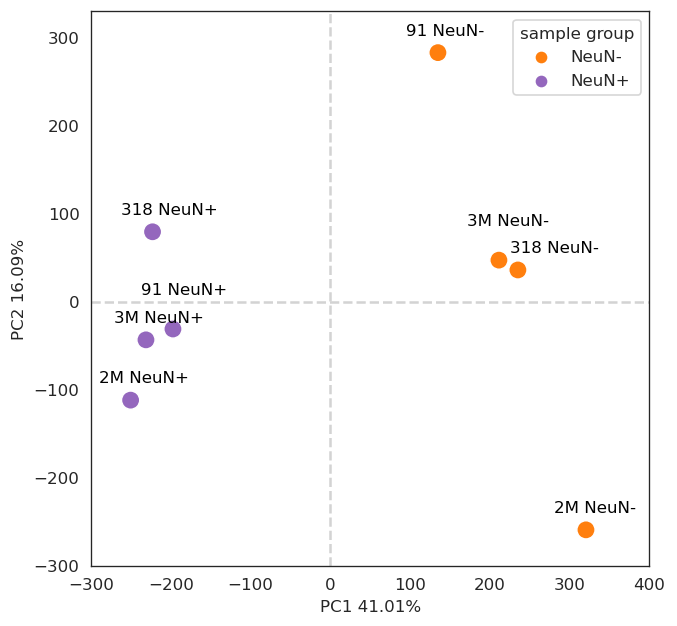

In [20]:
sns.set_style("white")
plt.figure(figsize=(6,6), dpi = 120)
my_pal = {"NeuN+": (sns.color_palette()[4]), "NeuN-": (sns.color_palette()[1])}
sns.scatterplot(data=components_df1, s=120, x="PC1", y="PC2", hue="sample group", palette = my_pal)
plt.axvline(0, 0,300, ls = '--', c = "lightgrey")
plt.axhline(0, 0,300, ls = '--', c = "lightgrey")
plt.ylim(-300,330)
plt.xlim(-300,400)
plt.xlabel("PC1 41.01%")
plt.ylabel("PC2 16.09%")

df = components_df1
for line in range(0,df.shape[0]):
    a = 20
    b = 40
    if line == 5 or line == 3:
        a = 40    
    if line == 0:
        b = 10  
    plt.text(df.PC1[line]-b, components_df1.PC2[line]+a, df["sample"][line], horizontalalignment='left',
              size='medium', color='black')
plt.show()